In [2]:
# import libraries and data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pyplot
import numpy as np
from sklearn.model_selection import train_test_split
import re

file_path = r'C:\Users\saman\physician-burnout-ml\Physician Burnout Survey.xlsx'
data = pd.read_excel(file_path)

In [3]:
# remove unecessary data and rename
clean_data = data.drop(columns=['Respondent ID', 'Collector ID', 'Start Date', 'End Date', 'IP Address', 'Email Address', 
                                'First Name', 'Last Name', 'Custom Data 1'])
clean_data = clean_data.drop(index=0, axis=0)
clean_data.columns=['Age', 'Gender', 'Specialty', 'Practice Type', 'Practice Size', 'New Patients', 'Years Worked',
                      'Patient Hours', 'EHR Hours', 'Admin Hours', 'Income Change', 'Burnout Level']

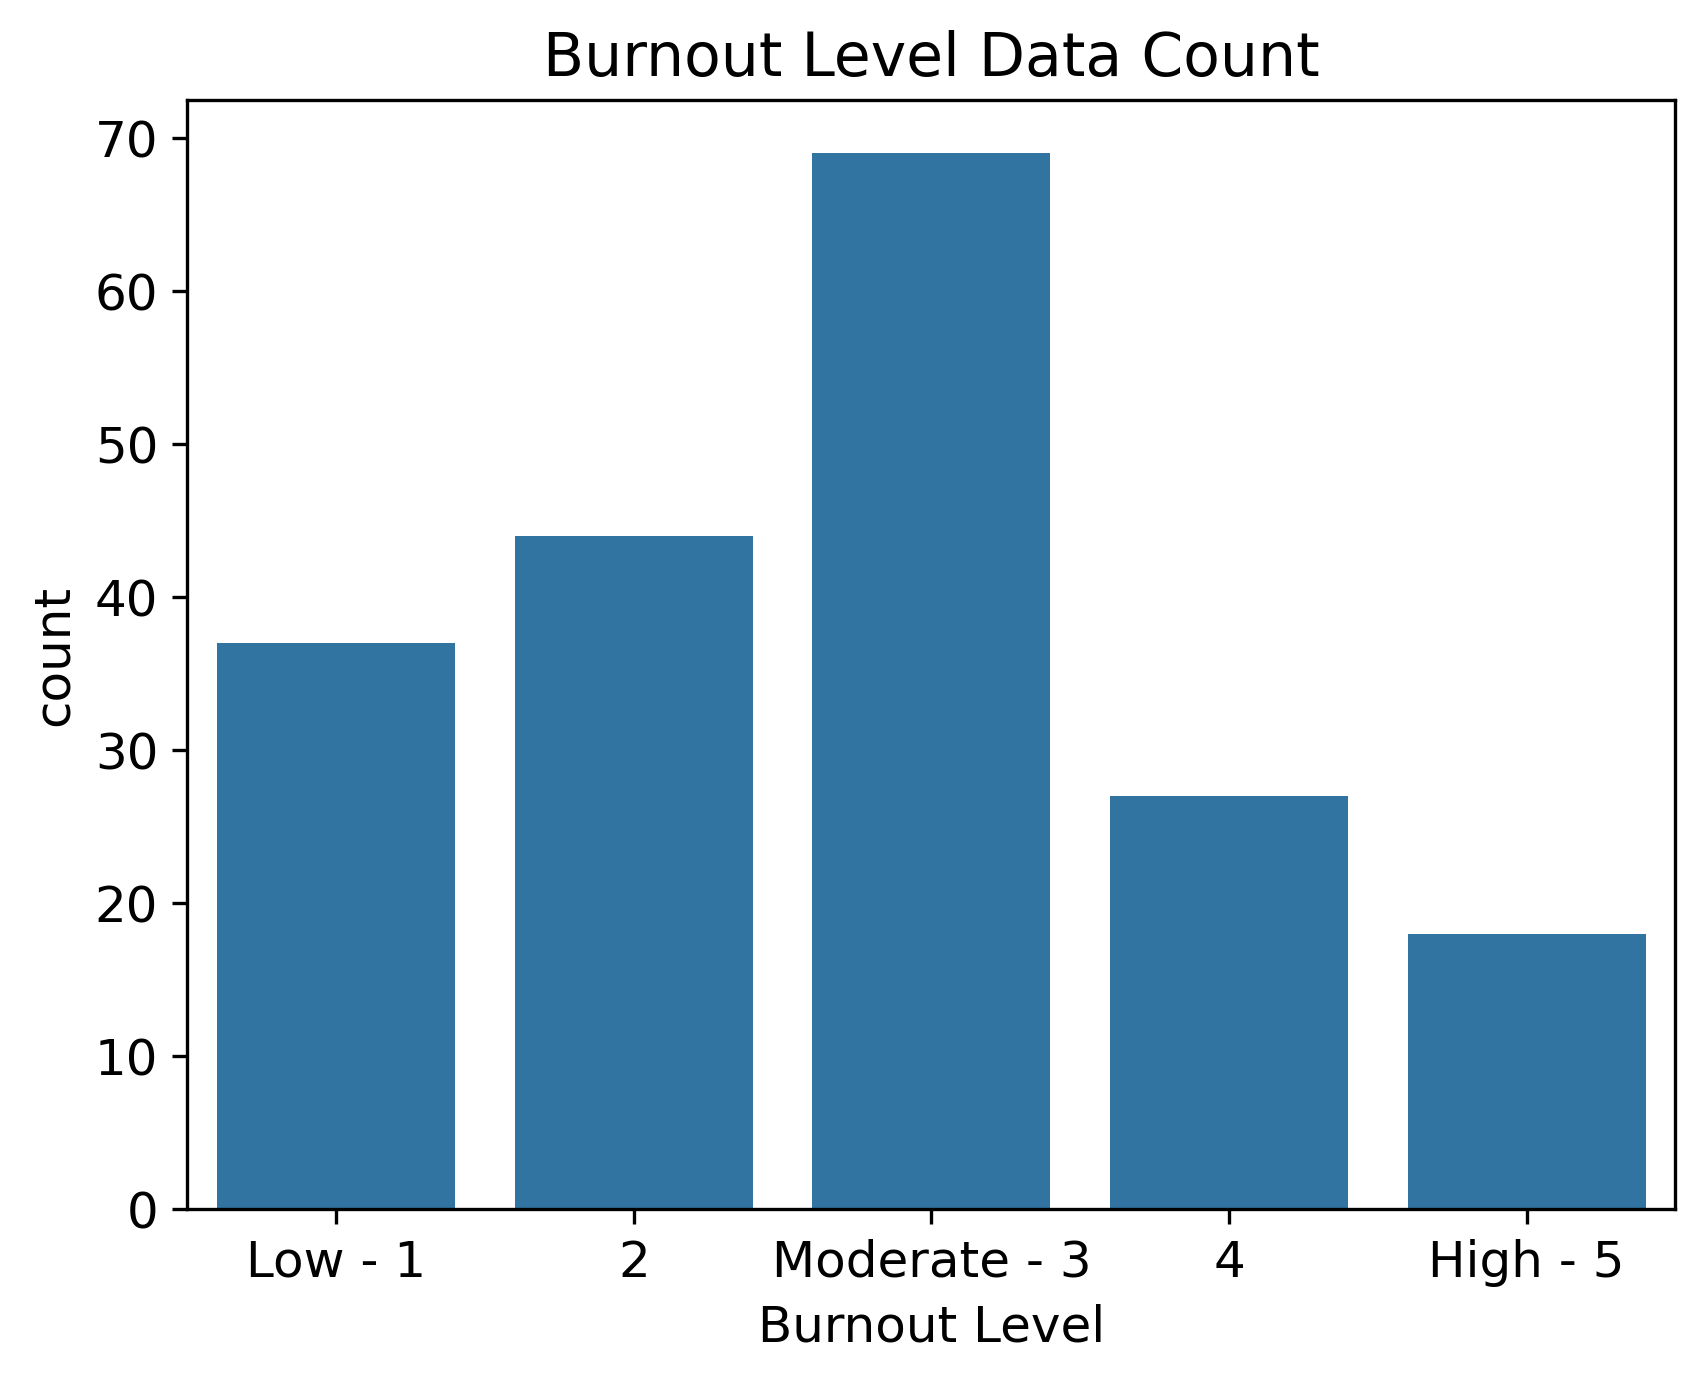

In [ ]:
# bar graph of burnout levels count
pyplot.rcParams['figure.dpi'] = 300
pyplot.rcParams['savefig.dpi'] = 300
pyplot.rcParams.update({'font.size': 12})

fig1 = sns.countplot(x = 'Burnout Level', data = clean_data, order=['Low - 1', '2', 'Moderate - 3', '4', 'High - 5'])
pyplot.title('Burnout Level Data Count')
burnout_count = fig1.get_figure()

In [ ]:
# graph of burnout correlated to hours on ehr, admin, and seeing patients

# bar graph of burnout

# 

In [12]:
Y = clean_data[['Burnout Level']].copy()
X = clean_data.drop(columns=['Burnout Level'])

print(Y.head(10))

# more data cleaning by column
Y['Burnout Level'] = Y['Burnout Level'][Y['Burnout Level'].size-2]
print(Y.head(10))

# remove words from burnout column


   Burnout Level
1              2
2              2
3        Low - 1
4   Moderate - 3
5              2
6   Moderate - 3
7        Low - 1
8              2
9              2
10           NaN
   Burnout Level
1        Low - 1
2        Low - 1
3        Low - 1
4        Low - 1
5        Low - 1
6        Low - 1
7        Low - 1
8        Low - 1
9        Low - 1
10       Low - 1
